[Guide](https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/)

In [13]:
# !pip freeze > requirements.txt

In [ ]:
# !pip install -r requirements.txt

# Install PyTorch

In [1]:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Imports

In [2]:
from collections import defaultdict
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import subprocess
from time import time
import torchvision
import torchvision.transforms as T


# Load Model

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

# Define class names

In [5]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush']

# Prediction

In [6]:
def get_prediction(img_path):
    img = Image.open(img_path) # Load the image
    transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    pred = model([img]) # Pass the image to the model
    return pred[0]

# Define Pipeline

In [7]:
def object_detection_api(img_path, threshold=0.9, rect_th=2, text_size=1, text_th=2, show_img=False):
    found = []

    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB

    start = time()
    pred = get_prediction(img_path) # Get predictions
    end = time()

    for box,label,score in zip(pred['boxes'],pred['labels'],pred['scores']):
        top_left = (float(box[0]),float(box[1]))
        bottom_right = (float(box[2]),float(box[3]))
        box = (top_left,bottom_right)
        label = COCO_INSTANCE_CATEGORY_NAMES[int(label)]
        score = float(score)
        if label == 'person' and score >= threshold:
            found.append((label,score,box))
#             print(box,label,score)

    if show_img:
        for label, score, box in found:
            x_min, y_min = map(int,box[0])
            x_max, y_max = map(int,box[1])
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
            cv2.putText(img,label, (int(x_min+5*text_size),int(y_min+30*text_size)),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (255,0,0),thickness=text_th) # Write the prediction class
            cv2.putText(img,f'{round(score*100)}%', (int(x_min+5*text_size),int(y_min+70*text_size)),  cv2.FONT_HERSHEY_SIMPLEX, text_size, (255,0,0),thickness=text_th)

        plt.figure(figsize=(20,30)) # display the output image
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

    sec = end - start
    print(f'Object Detection took {round(sec, 3)} seconds on image size {img.shape}')
    return found, sec

# Run Object Detection

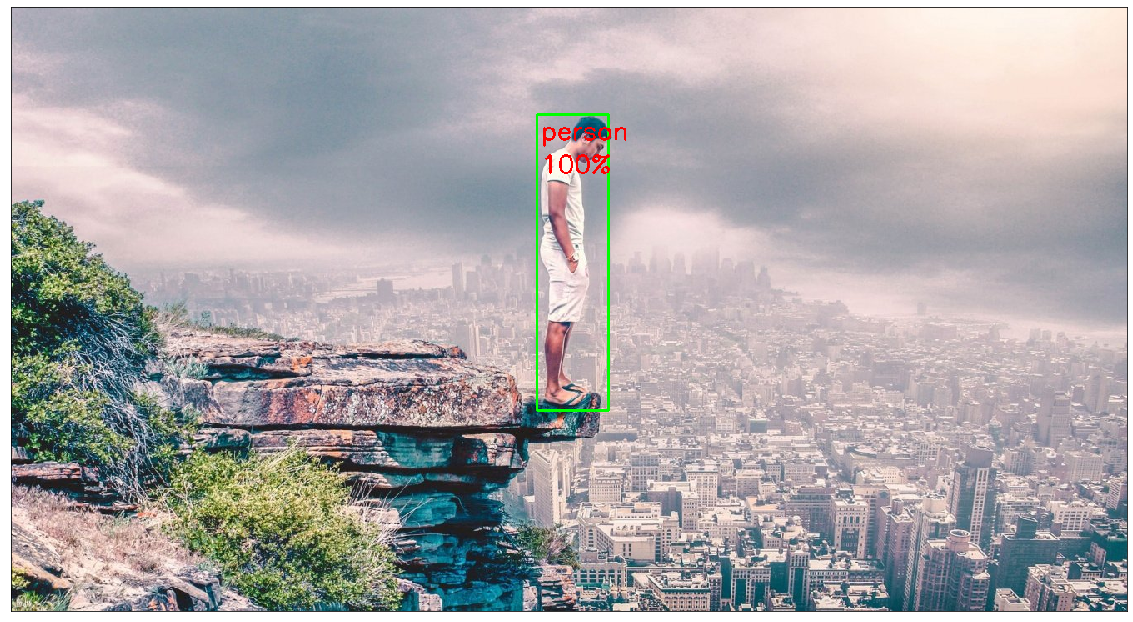

Object Detection took 4.563 seconds on image size (726, 1340, 3)


([('person',
   0.9970627427101135,
   ((631.3350830078125, 130.07675170898438),
    (717.4778442382812, 485.3580627441406)))],
 4.5625457763671875)

In [8]:
object_detection_api(f'./../src/imgs/one.jpg',show_img=True)

In [9]:
# timeout = 60*10 # 10 minutes
timeout = 60 # 1 minutes
files = ['one.jpg','two.jpg','three.webp','four.webp','five.png','six.jpg']

times = defaultdict(list)
for file in files:
    start = time()
    while time() - start < timeout:
        objects, duration = object_detection_api(f'./../src/imgs/{file}')
        times[file.capitalize()].append(duration)
    else:
        print(f'Image {file} done')

Object Detection took 4.855 seconds on image size (726, 1340, 3)
Object Detection took 4.888 seconds on image size (726, 1340, 3)
Object Detection took 4.664 seconds on image size (726, 1340, 3)
Object Detection took 4.83 seconds on image size (726, 1340, 3)
Object Detection took 5.471 seconds on image size (726, 1340, 3)
Object Detection took 4.797 seconds on image size (726, 1340, 3)
Object Detection took 4.846 seconds on image size (726, 1340, 3)
Object Detection took 4.906 seconds on image size (726, 1340, 3)
Object Detection took 4.941 seconds on image size (726, 1340, 3)
Object Detection took 5.073 seconds on image size (726, 1340, 3)
Object Detection took 5.007 seconds on image size (726, 1340, 3)
Object Detection took 5.045 seconds on image size (726, 1340, 3)
Image one.jpg done
Object Detection took 5.247 seconds on image size (337, 600, 3)
Object Detection took 5.262 seconds on image size (337, 600, 3)
Object Detection took 5.387 seconds on image size (337, 600, 3)
Object Det

# Statistics

In [12]:
def calc_stats(dataset, dataname):
    mean = float(np.round(np.mean(dataset), 3))
    median = float(np.round(np.median(dataset), 3))
    min_value = float(np.round(dataset.min(), 3))
    max_value = float(np.round(dataset.max(), 3))
    quartile_1 = float(np.round(dataset.quantile(0.25), 3))
    quartile_3 = float(np.round(dataset.quantile(0.75), 3))
    # Interquartile range
    iqr = np.round(quartile_3 - quartile_1, 3)
    lower_bound = np.round(quartile_1 - iqr * 1.5, 3)
    upper_bound = np.round(quartile_3 + iqr * 1.5, 3)

    print(f'{dataname} summary statistics')
    print(f'Min                      : {min_value}')
    print(f'Mean                     : {mean}')
    print(f'Max                      : {max_value}')
    print('')
    print(f'25th percentile          : {quartile_1}')
    print(f'Median                   : {median}')
    print(f'75th percentile          : {quartile_3}')
    print(f'Interquartile range (IQR): {iqr}')
    print('')
    print(f'Lower outlier bound      : {lower_bound}')
    print(f'Upper outlier bound      : {upper_bound}')
    print('--------------------------------')

for name, data in times.items():
    df = pd.DataFrame(data, columns=['Data'])
    calc_stats(df, name)

One.jpg summary statistics
Min                      : 4.664
Mean                     : 4.944
Max                      : 5.471

25th percentile          : 4.842
Median                   : 4.897
75th percentile          : 5.016
Interquartile range (IQR): 0.174

Lower outlier bound      : 4.581
Upper outlier bound      : 5.277
--------------------------------
Two.jpg summary statistics
Min                      : 5.247
Mean                     : 6.164
Max                      : 6.702

25th percentile          : 5.568
Median                   : 6.536
75th percentile          : 6.603
Interquartile range (IQR): 1.035

Lower outlier bound      : 4.015
Upper outlier bound      : 8.156
--------------------------------
Three.webp summary statistics
Min                      : 5.759
Mean                     : 6.022
Max                      : 6.507

25th percentile          : 5.8
Median                   : 6.004
75th percentile          : 6.152
Interquartile range (IQR): 0.352

Lower outlier bound  

c:\users\ejer\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
c:\users\ejer\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


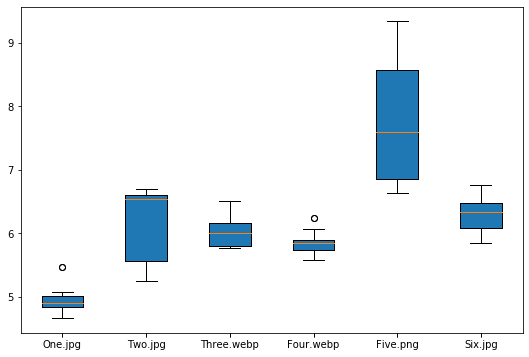

In [11]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(times.values())

## add patch_artist=True option to ax.boxplot()
## to get fill color
bp = ax.boxplot(times.values(), patch_artist=True)

## Custom x-axis labels
ax.set_xticklabels(times.keys())

## Remove top axes and right axes ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Save the figure
plt.show()